In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter, FFMpegWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
n_paricles = 16
r = torch.rand((2, n_paricles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

In [4]:
ids = torch.arange(n_paricles)

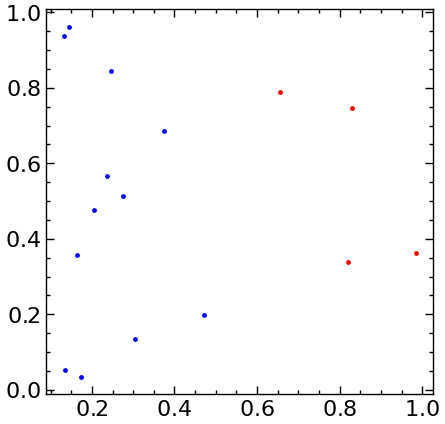

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(), r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(), r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. 
We'll make the particles starting on the RHS move to the left at 500m/s and ont LHS vice versa.

-**Note:** We're using the assumption that particles in a gas move at aprox. 500m/s, thanks google.



In [6]:
v = torch.zeros((2, n_paricles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

-   To determine if two particles collide, we need to find the distance between **all pairs** of particles. \
    If the distance is less then 2 times the radius of each particle, they collide. \
    If there are $n$ particles, there are $n(n-1)/2$ pairs (combinations). \
    To make this easier, we'll get particle IDs.


In [7]:
id_pairs = torch.combinations(ids, 2).to(device)

We can obtain distances between particles in a similar fashion
- First get the pairs of x-positions of all particles

In [8]:
x_pairs = torch.combinations(r[0],2).to(device)

-Then take the differnce to get $\Delta x_{i,j}$ of all pairs

In [9]:
#dx_pairs = torch.diff(x_pairs, axis=1).ravel()

The total distance is just $d_{i,j} = \sqrt{ \Delta x_{i,j}^2 + Δ y_{i,j}^2}$. Since there are $n(n-1)/2$ pairs, there will be
$n(n-1)/2$ different values of $d_{i,j}$.

In [10]:
x_pairs = torch.combinations(r[0],2).to(device)
dx_pairs = torch.diff(x_pairs, axis=1).ravel()

y_pairs = torch.combinations(r[1],2).to(device)
dy_pairs = torch.diff(y_pairs, axis=1).ravel()

d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate d_pairs, and if any of the distances between
particles are less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres?
In an elastic collision (conservation of energy + momentum + angular momentum), one can show
$$\overrightarrow{v}_{1}^{new} = \overrightarrow{v}_{1} - {{(\overrightarrow{v}_{1} - \overrightarrow{v}_{2}) \cdot (\overrightarrow{r}_{1} - \overrightarrow{r}_{2})} \over |\overrightarrow{r}_{1} - \overrightarrow{r}_{2}|^2} (\overrightarrow{r}_{1} - \overrightarrow{r}_{2})$$

$$\overrightarrow{v}_{2}^{new} = \overrightarrow{v}_{2} - {{(\overrightarrow{v}_{2} - \overrightarrow{v}_{1}) \cdot (\overrightarrow{r}_{2} - \overrightarrow{r}_{1})} \over |\overrightarrow{r}_{2} - \overrightarrow{r}_{1}|^2} (\overrightarrow{r}_{2} - \overrightarrow{r}_{1})$$


In [11]:
radius = 0.06
id_pair_collide = id_pairs[d_pairs < (2*radius)]

In [12]:
v1 = v[:, id_pair_collide[:,0]]
v2 = v[:, id_pair_collide[:,1]]
r1 = r[:, id_pair_collide[:,0]]
r2 = r[:, id_pair_collide[:,1]]

In [13]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) *(r1-r2) 
v2new = v2 - torch.sum((v2-v1)*(r2-r1), axis=0)/torch.sum((r2-r1)**2, axis=0) *(r2-r1) 

# Part 3: Functions to Run the Simulation

Here we define some functions that woöö help meke running the simulation easier

In [14]:
def get_delta_pairs(r):
    dx = torch.diff(torch.combinations(r[0],2).to(device)).squeeze()
    dy = torch.diff(torch.combinations(r[1],2).to(device)).squeeze()
    return torch.sqrt(dx*dx + dy*dy)

def compute_new_v(v1,v2,r1,r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) *(r1-r2) 
    v2new = v2 - torch.sum((v2-v1)*(r2-r1), axis=0)/torch.sum((r2-r1)**2, axis=0) *(r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    #initial state
    rs[0] = r
    vs[0] = v
    for i in range(1, ts):
        ic = id_pairs[get_delta_pairs(r) < d_cutoff]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(
            v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]],
        )
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position ao all particles as a function of time (3D array rs where each axis is $(t,x,y)$).

In [15]:
radius = 0.03
rs, vs = motion(r, v, id_pairs, ts=1000, dt=0.000008, d_cutoff=(2*radius))

Plot red and blue circles, making sure each is the correct size.

(0.0, 1.0)

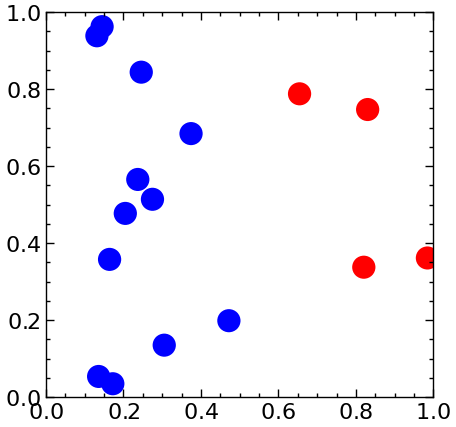

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl], rs[0][1][ixl]

circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred, yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue, yblue)]

cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')

ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)


Make initial animation of the simulation

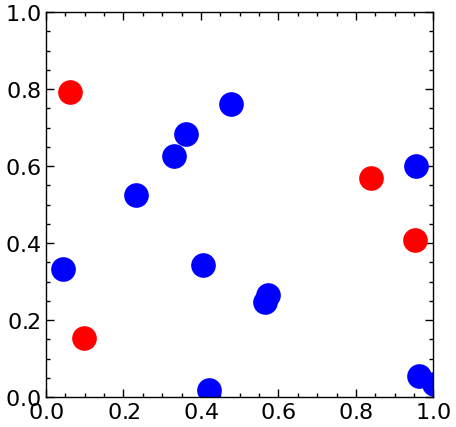

In [17]:
fig, ax = plt.subplots(1,1,figsize =(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([],[], 'o', color='red', markersize=markersize)
blue, = ax.plot([],[], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(), rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue


writer = PillowWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani.gif', writer=writer, dpi=100)


In [19]:
n_paricles = 4000
r = torch.rand((2,n_paricles)).to(device)
ixr = r[0]>0.5
ixl = r[0]<=0.5
ids = torch.arange(n_paricles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_paricles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=10000, dt=0.000008, d_cutoff=2*radius)

Let's look at the velocity distribution of the particles and compare it to MAxwell-Blotzmann in 2 Dimensions: 

- $kT = KE_{avg} = \frac{1}{2} m \bar{v}^2 → \frac{m}{kT} = \frac{2}{\bar{v}^2}$
- $f(v) = \frac{m}{kT}v\exp(-\frac{m}{kT}\frac{v^2}{2})$

In [20]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv= a*v*np.exp(-a*(v**2) / 2)

Plot the final histogram

Text(0, 0.5, '# Particles')

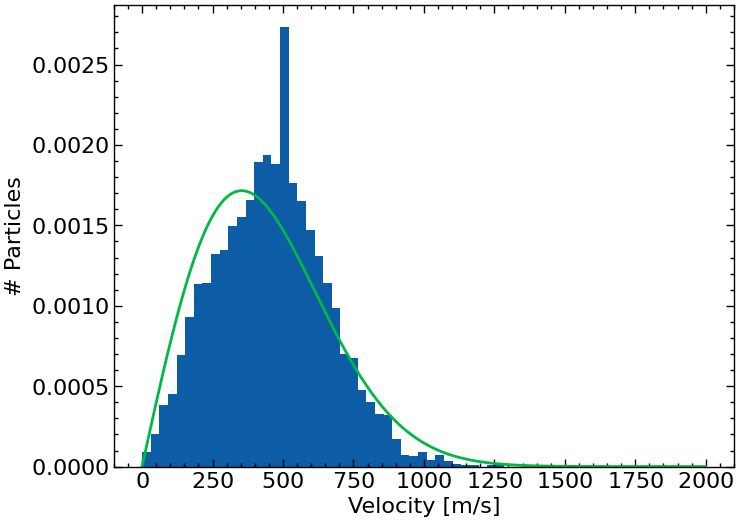

In [21]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[400]**2, axis=0)).cpu(), bins = bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')


Finally, we can make an animation of the particles moving around and the histogram at the same time.

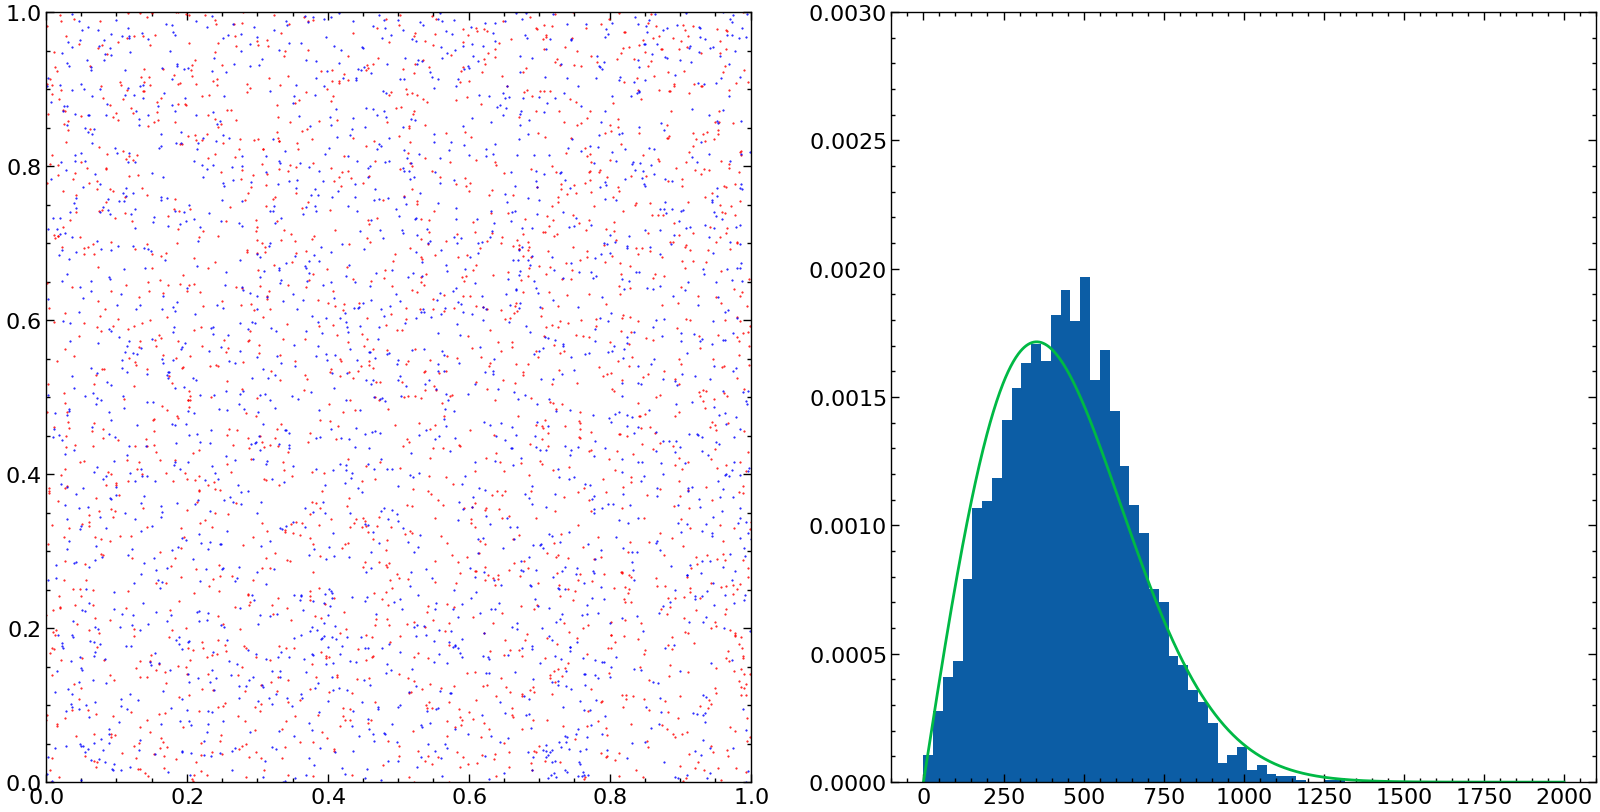

In [22]:
fig, axes = plt.subplots(1,2,figsize =(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([],[], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([],[], 'o', color='blue', markersize=markersize)


n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins = bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)


def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(), rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins = bins, density=True)
    
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue


writer = PillowWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save(f'ani_{n_paricles}.gif', writer=writer, dpi=100)